In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
import os
import cv2

path = 'drive/My Drive/BIOMETRIA/new_executions/crop_terravic'
images_train = []
images_test = []
images_val = []
labels_train = []
labels_test = []
labels_val = []
class_paths = []
for i in range(10):
  print(f'Loading class: {i}')
  faces_train_class = next(os.walk(f'{path}/{i+1}/train'))[2]
  
  faces_test_class = next(os.walk(f'{path}/{i+1}/test'))[2]
  faces_val_class = next(os.walk(f'{path}/{i+1}/validation'))[2]
  images_train += [f'{path}/{i+1}/train/{name_image}' for name_image in faces_train_class]
  class_paths.append([f'{path}/{i+1}/train/{name_image}' for name_image in faces_train_class])
  images_test += [f'{path}/{i+1}/test/{name_image}' for name_image in faces_test_class]
  images_val += [f'{path}/{i+1}/validation/{name_image}' for name_image in faces_val_class]
  labels_train += [i for j in range(len(faces_train_class))]
  labels_test += [i for j in range(len(faces_test_class))]
  labels_val += [i for j in range(len(faces_val_class))]
  

Loading class: 0
Loading class: 1
Loading class: 2
Loading class: 3
Loading class: 4
Loading class: 5
Loading class: 6
Loading class: 7
Loading class: 8
Loading class: 9


In [5]:
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms

hparams = {
    'batch_size':64,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':1728,
    'learning_rate':1e-5,
    'log_interval':1,
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

class CustomDataset(Dataset):
  def __init__(self, images_paths, labels, transform=None):
    self.images_paths = images_paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images_paths)

  def __getitem__(self, index):
    img_path = self.images_paths[index]
    image = cv2.imread(img_path)
    
    if self.transform:
      image = self.transform(image)
    
    return (image, int(self.labels[index]))



In [6]:
train_dataset = CustomDataset(images_train, labels_train, transforms.ToTensor())
test_dataset = CustomDataset(images_test, labels_test, transforms.ToTensor())
val_dataset = CustomDataset(images_val, labels_val, transforms.ToTensor())

from torch.utils.data import DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = DataLoader(
    test_dataset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

val_loader = DataLoader(
    val_dataset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)



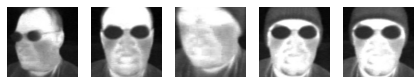

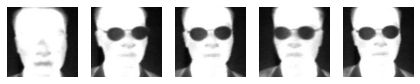

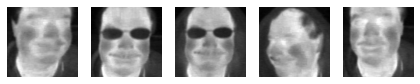

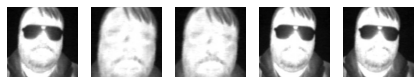

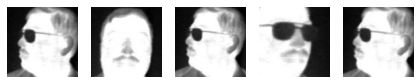

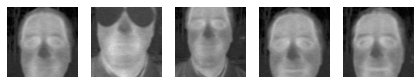

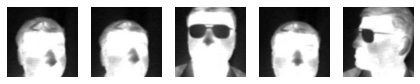

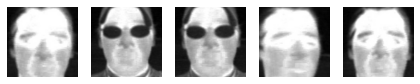

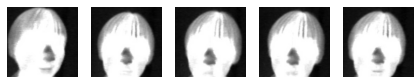

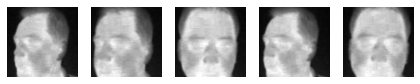

In [85]:

def plot_images(images):
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

for i in range(10):
  images_class = []
  for j in range(5):
    path = class_paths[i][j]
    img_class = cv2.imread(f'{path}')
    images_class.append(img_class)
  plot_images(images_class)

**Modified VGG-16 with pretrained weights**

First convolutional layer is replaced by one channel combination of original weights since the images are in grayscale.

The classifier was replaced by a new MLP with 10 outputs.

In [48]:
import torch.nn as nn
import torchvision.models as models

class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()

      vgg=models.vgg16(pretrained = True).features #load upto the classification layers except first conv layer

      self.vgg =nn.Sequential(
          vgg,
          nn.MaxPool2d(6, stride=2)
          )

      for param in self.vgg.parameters():
        param.requires_grad = False

      self.classifier = nn.Sequential(
          nn.Linear(512*1*1, 1000),
          nn.ReLU(inplace=True),
          nn.Linear(1000, 10),
          nn.LogSoftmax(dim=-1)
      )

  def forward(self, x):
      x = self.vgg(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)

      return x

In [17]:
models.vgg16(pretrained = True).features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [11]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [49]:
import torch.optim as optim
import torch.nn.functional as F

tr_losses = []
te_losses = []
te_accs = []
network = Net()
network.to(hparams['device'])
optimizer = optim.RMSprop(network.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

for epoch in range(1, hparams['num_epochs'] + 1):
  tr_losses.append(train_epoch(train_loader, network, optimizer, criterion, hparams))
  te_loss, te_acc = test_epoch(val_loader, network, hparams)
  te_losses.append(te_loss)
  te_accs.append(te_acc)

Train Epoch: 1 [0/3307 (0%)]	Loss: 2.302550
Train Epoch: 1 [64/3307 (2%)]	Loss: 2.186553
Train Epoch: 1 [128/3307 (4%)]	Loss: 2.114338
Train Epoch: 1 [192/3307 (6%)]	Loss: 2.053702
Train Epoch: 1 [256/3307 (8%)]	Loss: 2.093861
Train Epoch: 1 [320/3307 (10%)]	Loss: 1.970623
Train Epoch: 1 [384/3307 (12%)]	Loss: 1.974680
Train Epoch: 1 [448/3307 (13%)]	Loss: 2.053514
Train Epoch: 1 [512/3307 (15%)]	Loss: 1.909044
Train Epoch: 1 [576/3307 (17%)]	Loss: 1.920264
Train Epoch: 1 [640/3307 (19%)]	Loss: 1.935368
Train Epoch: 1 [704/3307 (21%)]	Loss: 1.909581
Train Epoch: 1 [768/3307 (23%)]	Loss: 1.862634
Train Epoch: 1 [832/3307 (25%)]	Loss: 1.938640
Train Epoch: 1 [896/3307 (27%)]	Loss: 1.832580
Train Epoch: 1 [960/3307 (29%)]	Loss: 1.952285
Train Epoch: 1 [1024/3307 (31%)]	Loss: 1.871288
Train Epoch: 1 [1088/3307 (33%)]	Loss: 1.830456
Train Epoch: 1 [1152/3307 (35%)]	Loss: 1.872957
Train Epoch: 1 [1216/3307 (37%)]	Loss: 1.828103
Train Epoch: 1 [1280/3307 (38%)]	Loss: 1.814476
Train Epoch: 1 [

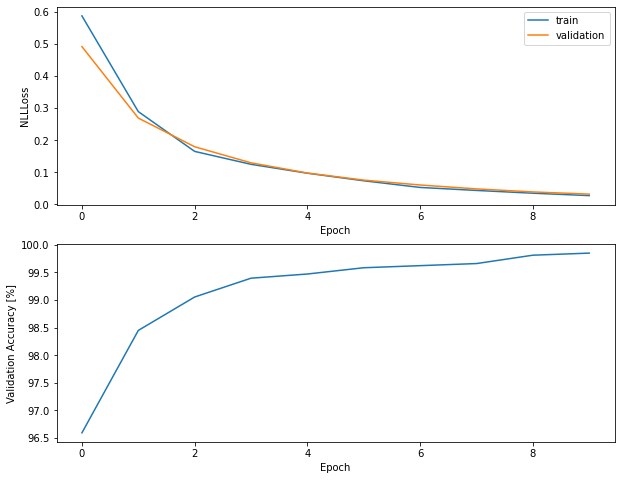

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(tr_losses, label='train')
plt.plot(te_losses, label='validation')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy [%]')
plt.plot(te_accs)

In [51]:
import pickle
test_loss, test_acc = test_epoch(test_loader, network, hparams)
results = {
    "loss_train": tr_losses,
    "loss_validation": te_losses,
    "val_accuracy": te_accs,
    "test_accuracy": test_acc
}

with open('results-512_1_1.pickle', 'wb') as handle:
  pickle.dump(results, handle)


Test set: Average loss: 0.5778, Accuracy: 643/668 (96%)



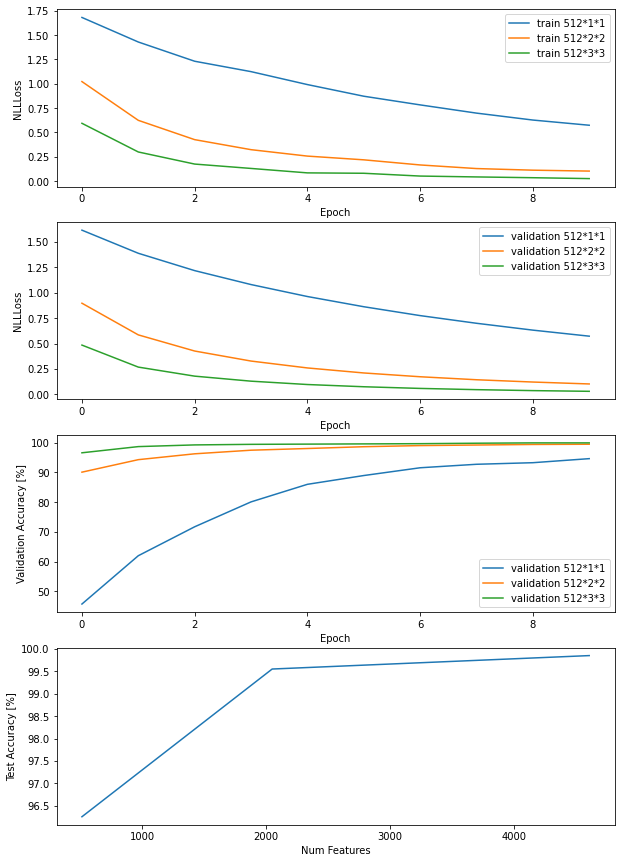

In [65]:
with open('results-512_1_1.pickle', 'rb') as handle:
  results_512_1 = pickle.load(handle)

with open('results-512_2_2.pickle', 'rb') as handle:
  results_512_2 = pickle.load(handle)

with open('results-512_3_3.pickle', 'rb') as handle:
  results_512_3 = pickle.load(handle)

from matplotlib import pyplot as plt

plt.figure(figsize=(10, 15))

plt.subplot(4,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(results_512_1['loss_train'], label='train 512*1*1')
plt.plot(results_512_2['loss_train'], label='train 512*2*2')
plt.plot(results_512_3['loss_train'], label='train 512*3*3')
plt.legend()

plt.subplot(4,1,2)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(results_512_1['loss_validation'], label='validation 512*1*1')
plt.plot(results_512_2['loss_validation'], label='validation 512*2*2')
plt.plot(results_512_3['loss_validation'], label='validation 512*3*3')
plt.legend()

plt.subplot(4,1,3)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy [%]')
plt.plot(results_512_1['val_accuracy'], label='validation 512*1*1')
plt.plot(results_512_2['val_accuracy'], label='validation 512*2*2')
plt.plot(results_512_3['val_accuracy'], label='validation 512*3*3')
plt.legend()

test_acc = [results_512_1['test_accuracy'], results_512_2['test_accuracy'], results_512_3['test_accuracy']]
num_features = [512, 512*2*2, 512*3*3]

plt.subplot(4,1,4)
plt.xlabel('Num Features')
plt.ylabel('Test Accuracy [%]')
plt.plot(num_features, test_acc)